# Setup

In [316]:
# Basico
import pandas as pd
import numpy as np
from IPython.display import display

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Sklearn
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

# Scipy
from scipy.stats import skew
from scipy.stats.mstats import winsorize

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning, DomainWarning

# Pygam
from pygam import LinearGAM, s, f

# Sistema
import os
import warnings
import logging

# MLFlow
import mlflow.sklearn
import mlflow.statsmodels
from mlflow.models.signature import infer_signature

# Config
pd.options.display.max_columns = 100
mlflow.set_tracking_uri("file:../models/mlruns")
logging.getLogger("mlflow.models.model").setLevel(logging.ERROR)

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DomainWarning)

### Funções

In [327]:
# Calcula a correlação (Mutual Information) do dia da semana no daureal
def compute_mutual_info(df, n_bins=5):
    df_proc = df.copy()
    
    # Discretização com qcut
    unique_count = df_proc['daureal'].nunique()
    if unique_count <= 1:
        df_proc['daureal_binned'] = 0
    else:
        bins = min(n_bins, unique_count)
        df_proc['daureal_binned'] = pd.qcut(
            df_proc['daureal'],
            q=bins,
            labels=False,
            duplicates='drop'
        )
    
    # Codifica categorias
    for col in ['dia_semana']:
        df_proc[f'{col}_encoded'] = LabelEncoder().fit_transform(df_proc[col])
    
    # Calcula MI
    x = df_proc[['dia_semana_encoded']]
    y = df_proc['daureal_binned']
    mi = mutual_info_classif(x, y, discrete_features=True)
    
    return pd.Series(mi, index=x.columns).sort_values(ascending=False)


# Métrica MedAPE
def medape(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

# Linear Mixed-Effects - modela considerando dia_semana, retorna RMSE médio e MedAPE médio
def pipeline_mixedlm(df, num_cols, cat_col='dia_semana', group_col='appid'
                     , n_splits=5, target='target', reml=False, re_formula='1'):
    
    gkf = GroupKFold(n_splits=n_splits)
    rmses = []
    medapes = []

    for tr_idx, te_idx in gkf.split(df, groups=df[group_col]):
        train, test = df.iloc[tr_idx], df.iloc[te_idx]
        formula = f"{target} ~ C({cat_col}) + " + " + ".join(num_cols)

        # passa re_formula aqui
        model = smf.mixedlm(formula,
                            data=train,
                            groups=train[group_col],
                            re_formula=re_formula)
        # e passa reml aqui
        fit = model.fit(reml=reml)

        preds = fit.predict(test)
        preds = np.expm1(preds)
        test[target] = np.expm1(test[target])

        rmses.append(np.sqrt(mean_squared_error(test[target], preds)))
        medapes.append(medape(test[target].values, preds))

    return np.mean(rmses), np.mean(medapes)


# GLM - modela apenas efeitos fixos, sem variações individuais por app (além do GroupKFold)
def pipeline_glm(df, num_cols, cat_col='dia_semana', group_col='appid', n_splits=5, target='target', family='gaussian'):

    # Escolha da família GLM
    families = {
        'gaussian': sm.families.Gaussian(),
        'poisson': sm.families.Poisson(),
        'binomial': sm.families.Binomial(),
        'gamma': sm.families.Gamma()
    }
    fam = families.get(family, sm.families.Gaussian())

    gkf = GroupKFold(n_splits=n_splits)
    rmses, medapes = [], []

    for train_idx, test_idx in gkf.split(df, groups=df[group_col]):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        
        formula = '{} ~ C({}) + {}'.format(target, cat_col, ' + '.join(num_cols))
        model = smf.glm(formula=formula, data=train, family=fam)
        fit = model.fit()

        preds = fit.predict(test)
        preds = np.expm1(preds)
        test[target] = np.expm1(test[target])
        
        rmses.append(np.sqrt(mean_squared_error(test[target], preds)))
        medapes.append(medape(test[target].values, preds))

    return np.mean(rmses), np.mean(medapes)

### Carrega

In [328]:
df_tratada = pd.read_csv("../data/base_tratada.csv").convert_dtypes()
df_tratada['date'] = pd.to_datetime(df_tratada['date'])
df_tratada = df_tratada.sort_values(['appid','date'])

df_tratada.head()

,appid,date,newinstalls,predictionloss,daureal,maureal,category,ratings,daily_ratings,reviews,daily_reviews
71,com.app.13655,2024-01-01,881,1569,10149,77387,FINANCE,62744,1,26406,1
3235,com.app.13655,2024-01-02,884,1611,19326,77215,FINANCE,62745,-1,26407,-1
4662,com.app.13655,2024-01-03,883,1613,19887,77025,FINANCE,62744,2,26406,1
1490,com.app.13655,2024-01-04,882,1611,18978,76756,FINANCE,62746,-1,26407,0
4920,com.app.13655,2024-01-05,881,1583,19143,76369,FINANCE,62740,-1,26402,-1


# Novas features

In [329]:
# Target (daureal d+1)
df_tratada['target'] = df_tratada.groupby('appid')['daureal'].shift(-1)

# Target d+7 soma movel
df_tratada['target_d7'] = df_tratada.groupby('appid')['daureal'].transform(lambda x: x.shift(-1).rolling(window=7, min_periods=1).sum())

# Baseline (hoje = ontem)
df_tratada['baseline'] = df_tratada.groupby('appid')['daureal'].shift(1)
df_tratada['target_lag'] = df_tratada['baseline'].copy()

# Dia da semana
df_tratada['dia_semana'] = df_tratada['date'].dt.day_name()

# Cria features de média movel e delta
for val in [3,7]:
    # Delta não foi relevante
    # df_tratada[f'ratings_delta{val}'] = df_tratada.groupby('appid')['ratings'].diff(periods=val)
    # df_tratada[f'reviews_delta{val}'] = df_tratada.groupby('appid')['reviews'].diff(periods=val)

    df_tratada[f'daily_ratings_ma{val}'] = df_tratada.groupby('appid')['daily_ratings'].transform(lambda x: x.rolling(val, min_periods=1).mean())
    df_tratada[f'predictionloss_ma{val}'] = df_tratada.groupby('appid')['predictionloss'].transform(lambda x: x.rolling(val, min_periods=1).mean())

    df_tratada[f'target_lag{val}'] = df_tratada.groupby('appid')['target'].shift(periods=val)

df_tratada['install_uninstall_diff'] = df_tratada['newinstalls'] - df_tratada['predictionloss']
df_tratada['daureal_maureal'] = df_tratada['daureal'] / df_tratada['maureal']
df_tratada['reviews_por_1kdau'] = df_tratada['daily_reviews'] / (df_tratada['daureal']/1000)
df_tratada['ratings_por_install'] = df_tratada['daily_ratings'].astype(int) / df_tratada['newinstalls'].astype(int)

df_tratada.dropna(inplace=True)
df_tratada.replace([np.inf, -np.inf], 0, inplace=True)

# Análise

In [330]:
colunas_numericas = df_tratada.select_dtypes(include=['number']).columns.tolist()
colunas_categoricas = ['category','dia_semana']

### Correlações - Pearson
- Correlação de Pearson das variáveis numéricas
> Correlação estranha: número de desinstalações passadas não tem correlação com DAU futuro <br>
> diff "instalações - desinstalações" tem correlação negativa com DAU

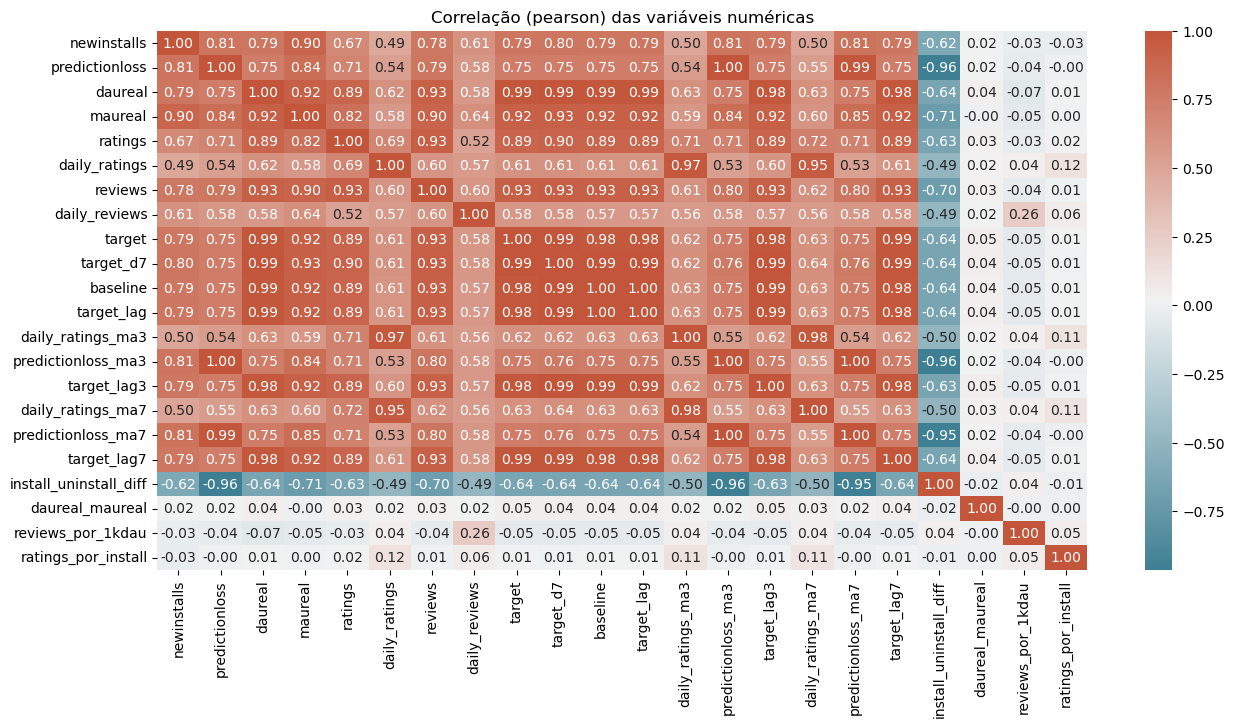

In [331]:
# Correlação geral (dados totalmente agrupados)
df_corr = df_tratada[colunas_numericas].corr()

plt.figure(figsize=(15,7))
sns.heatmap(df_corr, annot=True, cmap=cmap, fmt='.2f')
plt.title("Correlação (pearson) das variáveis numéricas")
plt.show()

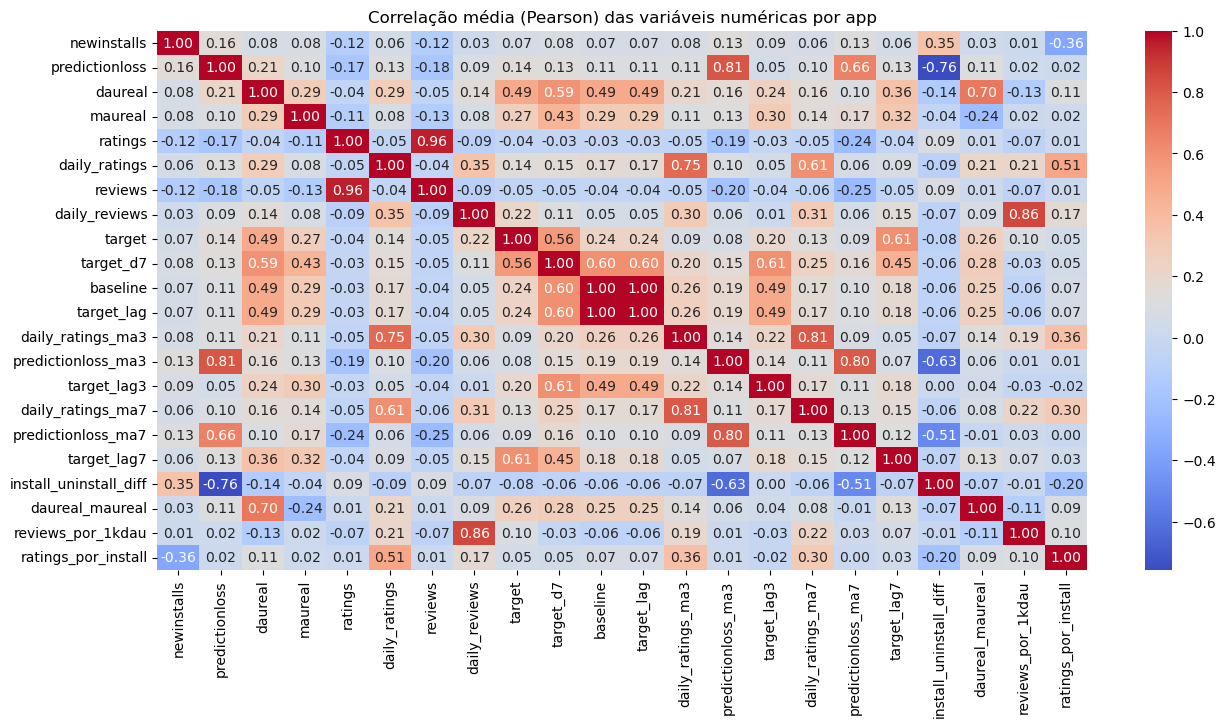

In [332]:
# Média da correlação por app individualmente

# Lista para armazenar matrizes de correlação por appid
corr_matrizes = []

# Iterar por appid
for app_id, grupo in df_tratada.groupby('appid'):
    corr = grupo[colunas_numericas].corr()
    
    if corr['newinstalls'].isna().sum() == 0:
        corr_matrizes.append(corr)

# Média das correlações (mesmo índice/colunas)
mean_corr = sum(corr_matrizes) / len(corr_matrizes)

# Plotar o heatmap da média
plt.figure(figsize=(15, 7))
sns.heatmap(mean_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlação média (Pearson) das variáveis numéricas por app")
plt.show()

### Correlações - MI
- Correlação de category e dia_semana com daureal usando mutual information

> Correlação extremamente baixa: possível influência da escala dos apps. <br>
> Ao fazer correlação por app individualmente, estabilizou em 30%.

In [333]:
# Correlação geral (dados totalmente agrupados)

# Discretizar daureal
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df_tratada['daureal_binned'] = kbins.fit_transform(df_tratada[['daureal']])

# Codificar variáveis categóricas
for col in ['category', 'dia_semana']:
    df_tratada[col + '_encoded'] = LabelEncoder().fit_transform(df_tratada[col])
    
# Calcular mutual information
x = df_tratada[['category_encoded', 'dia_semana_encoded']]
y = df_tratada['daureal_binned'].ravel()

mi = mutual_info_classif(x, y, discrete_features=True)

# Visualização
mi_series = pd.Series(mi, index=x.columns).sort_values(ascending=False)
print(mi_series)

category_encoded      0.098276
dia_semana_encoded    0.002290
dtype: float64


In [334]:
# Correlação de MI feita por app individualmente
mi_list = []
for app_id, grupo in df_tratada[['appid','daureal','dia_semana']].groupby('appid', observed=False):
    scores = compute_mutual_info(grupo)
    scores.name = app_id
    mi_list.append(scores)
mi_por_app = pd.DataFrame(mi_list)

print(f"Correlação de daureal com dia_semana: {round(mi_por_app.mean().iloc[0],3)}")

Correlação de daureal com dia_semana: 0.314


# Seleção de Features

In [335]:
df_model = df_tratada.copy()

non_feature_cols = ['target','target_d7','baseline']
target = ['target']
all_features = [x for x in colunas_numericas if x not in non_feature_cols]
len(all_features)

19

In [336]:
mean_corr[np.abs(mean_corr['target'])>=0.20].target.mean()

0.4302729794662624

In [337]:
# Filtra top features por correlação
features_by_corr = list(mean_corr[np.abs(mean_corr['target'])>=0.20].index)
features_by_corr.remove('target')
features_by_corr.append('dia_semana')
features_by_corr

['daureal',
 'maureal',
 'daily_reviews',
 'target_d7',
 'baseline',
 'target_lag',
 'target_lag7',
 'daureal_maureal',
 'dia_semana']

In [338]:
# Usa feature_importance pra selecionar features
model = (RandomForestRegressor(max_depth=8, n_estimators=100, n_jobs=-1)
         .fit(df_model[all_features], df_model[target].values.ravel()))

importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

features_by_importance = list(importance_df.head(5).feature)
features_by_importance.append('dia_semana')
importance_df.head(5)

,feature,importance
2,daureal,0.390895
14,target_lag7,0.265911
8,target_lag,0.218639
11,target_lag3,0.110091
6,reviews,0.008010


In [339]:
# Features finais
final_features = list(set(features_by_importance + features_by_corr))
final_features.remove('baseline')
final_features.remove('target_d7')

final_features

['target_lag3',
 'daily_reviews',
 'target_lag',
 'maureal',
 'daureal_maureal',
 'reviews',
 'target_lag7',
 'daureal',
 'dia_semana']

# Tratamento de outliers e scaling
- Trata outliers da tabela final

array([[<Axes: title={'center': 'target'}>]], dtype=object)

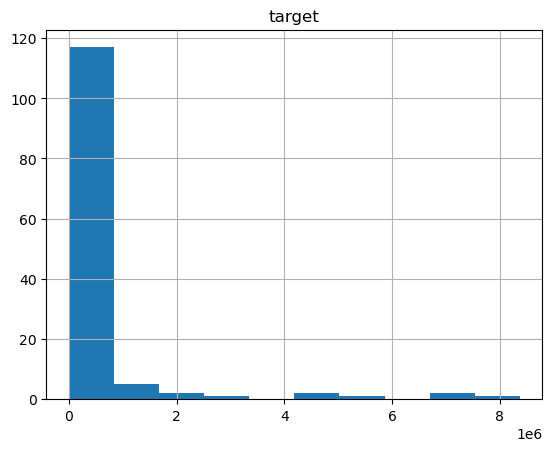

In [340]:
# Distribuição de outliers: daureal médio
df_tratada.groupby('appid',as_index=False)['target'].mean().hist()

In [341]:
# Dicionário para limiar do winsorize
skew_to_limit = {
    0.5: 0.01,
    1.0: 0.03,
    2.0: 0.05,
    float('inf'): 0.10
}

# Normaliza por log se existirem só valores positivos, do contrário usa winsorize dinâmico
for col in np.sort(colunas_numericas):
    if df_model[col].min()>0:
        df_model[col] = np.log1p(df_model[col])
    else:
        sk = abs(skew(df_model[col].dropna().astype(float)))
        limit = next(v for k, v in skew_to_limit.items() if sk <= k)
        df_model[col] = winsorize(df_model[col].astype(float), limits=[limit, limit])

array([[<Axes: title={'center': 'target'}>]], dtype=object)

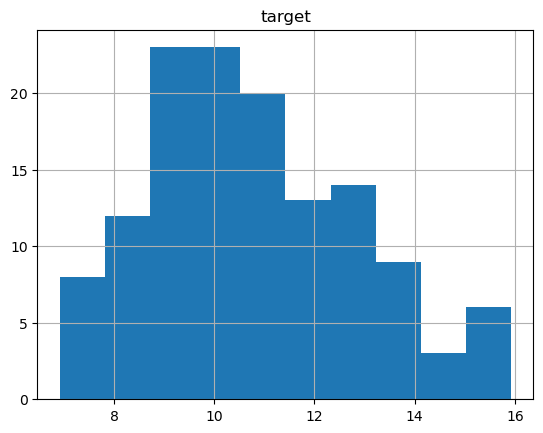

In [342]:
# Distribuição de outliers: log
df_model.groupby('appid',as_index=False)['target'].mean().hist()

# Modelos

In [343]:
# Describe da df final
describe_df_model = df_model[final_features + target].describe().T
describe_df_model

,count,mean,std,min,25%,50%,75%,max
target_lag3,34292.0,10.825043,2.106095,6.621406,9.282056,10.573468,12.200068,16.180897
daily_reviews,34292.0,11.746938,16.824673,0.0,1.0,3.0,15.0,52.0
target_lag,34292.0,10.824759,2.106353,6.621406,9.281823,10.57398,12.199814,16.180897
maureal,34292.0,12.825593,1.854668,7.639642,11.49224,12.62664,13.954412,17.188215
daureal_maureal,34292.0,0.146877,0.125536,0.00041,0.086153,0.11892,0.182843,7.021583
reviews,34292.0,9.695714,2.044251,4.969813,8.215006,9.745663,11.103652,14.214967
target_lag7,34292.0,10.826919,2.105098,6.621406,9.284636,10.576496,12.201753,16.180897
daureal,34292.0,10.824517,2.106572,6.621406,9.281544,10.574223,12.199398,16.180897
target,34292.0,10.824029,2.106832,6.621406,9.280776,10.572969,12.199398,16.180897


In [344]:
# Formata colunas do modelo
num_cols = [c for c in final_features if c != 'dia_semana']

df_model[num_cols + target] = df_model[num_cols + target].astype(np.float64)
df_model['dia_semana'] = df_model['dia_semana'].astype('category')
df_model['appid'] = df_model['appid'].astype('category')

### Baseline
- Gera a baseline de 2 targets: d+1 e d+7
- Usa RMSE e MedAPE

In [348]:
# Definição da baseline d+7
df_model['baseline_d7'] = df_model['baseline'].shift()
df_model.dropna(inplace=True)

# Treino e teste
y_true = df_model['target']
y_pred = df_model['baseline']

y_true_d7 = df_model['target_d7']
y_pred_d7 = df_model['baseline_d7']

# Desfaz log
y_pred = np.expm1(y_pred)
y_true = np.expm1(y_true)

y_pred_d7 = np.expm1(y_pred_d7)
y_true_d7 = np.expm1(y_true_d7)

# Cálculo de metricas
rmse_baseline = np.sqrt(mean_squared_error(y_true, y_pred))
medape_baseline = medape(y_true.values, y_pred.values)

rmse_baseline_d7 = np.sqrt(mean_squared_error(y_true_d7, y_pred_d7))
medape_baseline_d7 = medape(y_true_d7.values, y_pred_d7.values)

print(f"RMSE (baseline): {rmse_baseline:.2f}")
print(f"MedAPE (baseline): {medape_baseline:.2f}%\n")

print(f"RMSE d7 (baseline): {rmse_baseline_d7:.2f}")
print(f"MedAPE d7 (baseline): {medape_baseline_d7:.2f}%")

RMSE (baseline): 269267.28
MedAPE (baseline): 10.43%

RMSE d7 (baseline): 8826680.61
MedAPE d7 (baseline): 85.52%


### Linear Mixed-Effect
- Teste inicial LME

In [349]:
rmse_lme, medape_lme = pipeline_mixedlm(df_model, num_cols, target='target')
rmse_lme_d7, medape_lme_d7 = pipeline_mixedlm(df_model, num_cols, target='target_d7')

C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.expm1(test[target])
C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.expm1(test[target])
C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [350]:
print(f"RMSE (lme): {rmse_lme:.2f}")
print(f"MedAPE (lme): {medape_lme:.2f}%\n")

print(f"RMSE d7 (lme): {rmse_lme_d7:.2f}")
print(f"MedAPE d7 (lme): {medape_lme_d7:.2f}%")

RMSE (lme): 189014.93
MedAPE (lme): 9.62%

RMSE d7 (lme): 1557383.86
MedAPE d7 (lme): 9.28%


### GLM
- Teste inicial GLM

In [351]:
rmse_glm, medape_glm = pipeline_glm(df_model, num_cols, target='target')
rmse_glm_d7, medape_glm_d7 = pipeline_glm(df_model, num_cols, target='target_d7')

C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.expm1(test[target])
C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.expm1(test[target])
C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [352]:
print(f"RMSE (glm): {rmse_glm:.2f}")
print(f"MedAPE (glm): {medape_glm:.2f}%\n")

print(f"RMSE d7 (glm): {rmse_glm_d7:.2f}")
print(f"MedAPE d7 (glm): {medape_glm_d7:.2f}%")

RMSE (glm): 147561.93
MedAPE (glm): 5.97%

RMSE d7 (glm): 724486.13
MedAPE d7 (glm): 3.65%


# Hiperparâmetros + MLFlow
- Otimização dos hiperparâmetros com tracking no MLFLow

In [353]:
mlflow.set_experiment("mixedlm_vs_glm")

<Experiment: artifact_location='file:///c:/Users/User/Documents/.dev/Cases/rankmyapp_teste/notebooks/../models/mlruns/500317620984170799', creation_time=1748423024398, experiment_id='500317620984170799', last_update_time=1748423024398, lifecycle_stage='active', name='mixedlm_vs_glm', tags={}>

In [354]:
# Separa apps pra validação posterior
all_apps = df_model['appid'].unique()
np.random.seed(42)
n_val = int(len(all_apps) * 0.2)
val_apps = np.random.choice(all_apps, size=n_val, replace=False)

# Tira os apps de validação do df_model
df_model = df_model[~df_model['appid'].isin(val_apps)]

In [355]:
val_apps

array(['com.app.50760', 'com.app.37962', 'com.app.24391', 'com.app.35851',
       'com.app.91390', 'com.app.50792', 'com.app.62062', 'com.app.88311',
       'com.app.68335', 'com.app.31454', 'com.app.81754', 'com.app.31679',
       'com.app.59849', 'com.app.17441', 'com.app.82896', 'com.app.85231',
       'com.app.37148', 'com.app.68015', 'com.app.80569', 'com.app.72653',
       'com.app.24343', 'com.app.19821', 'com.app.95194', 'com.app.19872',
       'com.app.97802', 'com.app.41189'], dtype=object)

### LME
- Roda uma grade de hiperparametros do LME e salva os resultados no MLFlow

In [361]:
# Grid de parametros
mixedlm_grid = [
    {"reml": False, "re_formula": None},
    {"reml": False, "re_formula": "~ C(dia_semana)"},
    {"reml": True,  "re_formula": None},
]

glm_grid = [
    {"family": "gaussian"},
    {"family": "poisson"},
    {"family": "gamma"},
]

c_target = 'target'

# Run
for params in mixedlm_grid:
    with mlflow.start_run(run_name=f"mixedlm_{params['reml']}_{params['re_formula']}"):
        # log dos parâmetros
        mlflow.log_params(params)
        mlflow.log_param("modelo", "lme")
        mlflow.log_param("target", c_target)
        # executa pipeline
        rmse, mape = pipeline_mixedlm(
            df=df_model,
            num_cols=num_cols,
            cat_col="dia_semana",
            group_col="appid",
            n_splits=5,
            target=c_target,
            reml=params["reml"],
            re_formula=params["re_formula"]
        )
        # log das métricas
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("medape", mape)
        # treina modelo final em todo o dataset para registrar artefato
        formula = f"{c_target} ~ C(dia_semana) + " + " + ".join(num_cols)
        mdl = smf.mixedlm(formula, df_model, groups=df_model["appid"],
                          re_formula=params["re_formula"])
        fit = mdl.fit(reml=params["reml"])
        # grava o modelo
        mlflow.statsmodels.log_model(fit, artifact_path="mixedlm_model")

C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.expm1(test[target])
C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.expm1(test[target])
C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

### GLM
- Roda uma grade de hiperparametros do GLM e salva os resultados no MLFlow

In [362]:
# Grid de parametros
glm_grid = [
    {"family": "gaussian"},
    {"family": "poisson"},
    {"family": "gamma"},
]

# Grid pra salvar o modelo
families = {
    "gaussian": sm.families.Gaussian(),
    "poisson":  sm.families.Poisson(),
    "gamma":    sm.families.Gamma(),
}

c_target = 'target'

# Run
for params in glm_grid:
    with mlflow.start_run(run_name=f"glm_{params['family']}"):
        # Log dos parametros
        mlflow.log_param("family", params["family"])
        mlflow.log_param("modelo", "glm")
        mlflow.log_param("target", c_target)

        # pipeline
        rmse, mape = pipeline_glm(
            df=df_model,
            num_cols=num_cols,
            cat_col="dia_semana",
            group_col="appid",
            n_splits=5,
            target=c_target,
            family=params["family"]
        )
        # log metricas
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("medape", mape)
        # modelo final
        formula = f"{c_target} ~ C(dia_semana) + " + " + ".join(num_cols)
        glm = smf.glm(formula, df_model, family=families[params["family"]]).fit()
        mlflow.statsmodels.log_model(glm, artifact_path="glm_model")

C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.expm1(test[target])
C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.expm1(test[target])
C:\Users\User\AppData\Local\Temp\ipykernel_6568\2455608899.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea